# Step 1 : Camera Caliberation

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

# Image Paths

In [ ]:
chess_image_list = glob.glob('camera_cal/calibration*.jpg')
images_list = glob.glob('test_images/test*.jpg')

In [ ]:
def plot_images(img_1,img_2,row_no=1,col_no=2,size=(9,6),title_ax1="Original Image",title_ax2="Changed Image",gray=False):
    f, (ax1, ax2) = plt.subplots(row_no, col_no, figsize=size)
    ax1.imshow(img_1)
    ax1.set_title(title_ax1, fontsize=20)
    if gray:
        ax2.imshow(img_2,cmap='gray')
    else:
        ax2.imshow(img_2)
    ax2.set_title(title_ax2, fontsize=20)

In [ ]:
def camera_calibration(image_list,nx=9,ny=6):
    objectPoints = np.zeros((6*9,3), np.float32)
    objectPoints[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    #image_list = glob.glob('camera_cal/calibration*.jpg')
    i =1
    for fname in image_list:
            #image_name = cal_image.split('/', 1 )[1]
            file_name='test'
            img = cv2.imread(fname)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray_image, (nx,ny), None)
            # If found, add object points, image points
            if ret == True:
                objpoints.append(objectPoints)
                imgpoints.append(corners)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plot_images(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB),cv2.cvtColor(img, cv2.COLOR_BGR2RGB),1,2,(9,6),"Original Image",title_ax2="Changed Image")
            else:
                print("This image doesn't have the corner of (9,6)")
    return objpoints,imgpoints

In [ ]:
objpoints,imgpoints=camera_calibration(chess_image_list,9,6)

# 2. Undistorting Image 

In [ ]:
# Remove distortion from images
def remove_distortion(image,read_flag=False):
    if read_flag:
        img = cv2.imread(image)
    else:
        img=image
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    remove_dist = cv2.undistort(img, mtx, dist, None, mtx)
    return remove_dist

In [ ]:
for image in images_list:
    remove_dist=remove_distortion(image,True)
    plot_images(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB),cv2.cvtColor(remove_dist, cv2.COLOR_BGR2RGB),1,2,(9,6),"Original Image","Calibrate + Undistorted Image")

# Testing

[[ 13  14 103 ... 104 105 105]
 [ 14 103 103 ... 103 104 104]
 [103 102 103 ... 103 104 104]
 ...
 [  5   5   5 ...   7   7   7]
 [  5   5   5 ...   7   7   7]
 [  5   5   8 ...   7   7   7]]
uint8


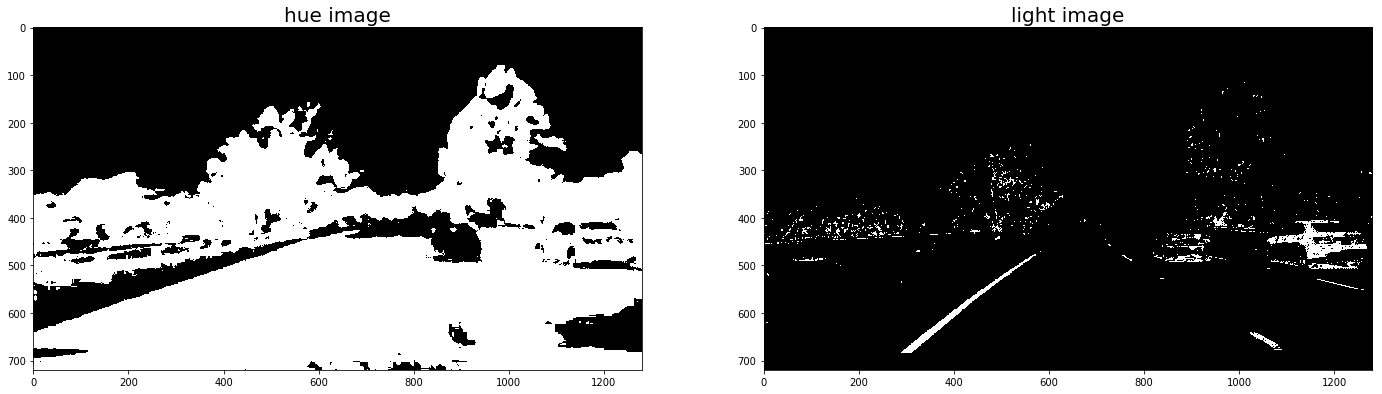

In [5]:
test = glob.glob('test_images/test1.jpg')
#img = cv2.imread(test[0])
img=mpimg.imread(test[0])
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h=hls[:,:,0]
l=hls[:,:,1]
s=hls[:,:,2]
thresh_h=(0,90)
thresh_s=(170,255)
binary = np.zeros_like(h)
binary[(h > thresh_h[0]) & (h <= thresh_h[1])] = 1
binary_s = np.zeros_like(s)
binary_s[(s > thresh_s[0]) & (s <= thresh_s[1])] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
print(h)
ax1.imshow(binary,cmap='gray')
ax1.set_title("hue image", fontsize=20)
ax2.imshow(binary_s,cmap='gray')
ax2.set_title("light image", fontsize=20)
#ax3.imshow(s)
#ax3.set_title("sat image", fontsize=20)
print(binary.dtype)

# 3. Color Channel Filtering 

In [ ]:
def color_channel_filtering(img,channel="S",read_flag=False):   
    image = remove_distortion(img,read_flag)
    if channel == "S":
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        thresh = (90, 255)
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    elif channel =="H":
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        thresh = (15, 100)
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif channel =="L":
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        L = hls[:,:,1]
        thresh = (15, 100)
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif channel =="Gray":
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        thresh = (180, 255)
        binary = np.zeros_like(gray)
        binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    elif channel =="R":
        R = image[:,:,0]
        thresh = (200, 255)
        binary = np.zeros_like(R)
        binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    elif channel =="C":
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        ## White Color
        lower_white = np.array([0,200,0], dtype=np.uint8)
        upper_white = np.array([255,255,255], dtype=np.uint8)
        white_mask = cv2.inRange(hls, lower_white, upper_white)
        ## Yellow Color
        lower_yellow = np.array([18,25,100], dtype=np.uint8)
        upper_yellow = np.array([30,220,255], dtype=np.uint8)
        yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)
        final_image = cv2.bitwise_and(hls,hls, mask = white_mask | yellow_mask)
#         combined_binary = np.zeros_like(white_mask)
#         combined_binary[(white_mask == 255) | (yellow_mask  == 30 )]=1
        final_image = cv2.cvtColor( final_image, cv2.COLOR_HLS2BGR)
        #final_image = cv2.cvtColor( final_image, cv2.COLOR_BGR2GRAY)
        return final_image
    else:
        print("Invalid value for color channel(Can take on )")
        return 0   
    return binary

In [ ]:
for image in images_list:
    #print(image.split('/', 1 ))
    binary=color_channel_filtering(image,"C",True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor( cv2.imread(image), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(binary)
    ax2.set_title('Channel yellow and white', fontsize=20)

In [ ]:
for image in images_list:
    #print(image.split('/', 1 ))
    binary=color_channel_filtering(image,"S",True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor( cv2.imread(image), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Channel S', fontsize=20)

# 4. Sobel Function , Gradient Thresholds

In [ ]:
def magnitude_sobel_thresh(img, sobel_kernel=3, mag_thresh=(30, 100),read_flag=False): 
    if read_flag:
         image = cv2.cvtColor(cv2.imread(img),cv2.COLOR_RGB2GRAY) 
    else:
        image=img
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

In [ ]:
def direction_sobel_threshold(img, sobel_kernel=3, thresh=(0, 3.10),read_flag=False):  
    if read_flag:
         image = cv2.cvtColor(cv2.imread(img),cv2.COLOR_RGB2GRAY) 
    else:
        image=img
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [ ]:
def abs_sobel_threshold(img,sobel_kernel=3,axis='x',thresh=(20,100),read_flag=False ):
    if read_flag:
         image =cv2.cvtColor(cv2.imread(img),cv2.COLOR_RGB2GRAY) 
    else:
        image=img
    if axis =='x':
        sobel_orient = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    elif axis =='y':
        sobel_orient = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    else:
        print("Wrong choice")
        return 0 
    abs_sobel = np.absolute(sobel_orient) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1  
    return sobel_binary 

In [ ]:
def combine_all_sobel_threshold(image,convertTo="G",kernal_size=15,read_flag=False):
    if read_flag:
        img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2HLS)
        img=img[:,:,2]
    else:
        img=image
    if convertTo =='G':
        img_con=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_con=cv2.cvtColor(img_con,cv2.COLOR_RGB2GRAY)
    else:
        img_con=image
    img_con=remove_distortion(img_con)
    sobel_x=abs_sobel_threshold(img_con,kernal_size,"x")
    sobel_y=abs_sobel_threshold(img_con,kernal_size,"y")
    dir_sobel=direction_sobel_threshold(img_con,kernal_size)
    mag_sobel=magnitude_sobel_thresh(img_con,kernal_size)
    combined_binary = np.zeros_like(dir_sobel)
    combined_binary[((sobel_x == 1) & (sobel_y == 1) ) & ((mag_sobel == 1)& (dir_sobel == 1))] = 1
    return combined_binary

In [ ]:
for image in images_list:         
    #print(image.split('/', 1 ))
    img = cv2.imread(image)
    img_hsl=cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L = img_hsl[:,:,2]
    #sobel_binary_x=abs_sobel_threshold(image,7,"x",(20,100),True)
    #sobel_binary_y=abs_sobel_threshold(image,7,"y",(20,100),True)   
    #dir_sobel=direction_sobel_threshold(image,15,(0.7, 1.3),True)
    #mag_sobel=magnitude_sobel_thresh(image,5,(30, 100),True)
    #combined_sobel=combine_all_sobel_threshold(image,'G',15,True)
    sobel_binary_x=abs_sobel_threshold(L,7,"x",(20,100))
    sobel_binary_y=abs_sobel_threshold(L,7,"y",(20,100))   
    dir_sobel=direction_sobel_threshold(L,15,(0.7, 1.3))
    mag_sobel=magnitude_sobel_thresh(L,5,(30, 100))
    combined_sobel=combine_all_sobel_threshold(L,'I',15)
    f, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(15, 10))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor( cv2.imread(image), cv2.COLOR_BGR2GRAY),cmap='gray')
    #ax1.imshow(l)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(sobel_binary_x, cmap='gray')
    ax2.set_title('sobel binary x', fontsize=10)
    ax3.imshow(sobel_binary_y, cmap='gray')
    ax3.set_title('sobel binary y', fontsize=10)
    ax4.imshow(dir_sobel, cmap='gray')
    ax4.set_title('sobel direction', fontsize=10)
    ax5.imshow(mag_sobel, cmap='gray')
    ax5.set_title('sobel magnitude', fontsize=10)
    ax6.imshow(combined_sobel, cmap='gray')
    ax6.set_title('sobel combined', fontsize=10)

# Combining Color filtering and Sobel

In [ ]:
# Testing on one image
def combine_color_gradient(image,read_flag=False):
    if read_flag:
        img = cv2.imread(image)
    else:
        img=image
    combine_sobel=combine_all_sobel_threshold(img,"L")
    color=color_channel_filtering(img)
    color_binary = np.dstack(( np.zeros_like(combine_sobel), combine_sobel, color)) * 255
    combined_binary = np.zeros_like(combine_sobel)
    combined_binary[(color == 1) | (combine_sobel[:,:,0] == 1)] = 1
    return combined_binary

In [ ]:
for image in images_list:
    com_im=combine_color_gradient(image,True)
    plot_images(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB),com_im,1,2,(9,6),"Original Image","Color+Gradiant Image",True)

# 5.Perspective Transform

In [ ]:
def perspective_transform(image,src, dst,read_flag=False):
    if read_flag:
        img = cv2.imread(image)
    else:
        img=image    
    img_size = (image.shape[1], image.shape[0])
    offset = 0
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size)
    src_pt=np.array(src, np.int32)
    dst_pt=np.array(dst,np.int32)
    #cv2.polylines(remove_dist_img,[src_pt],True,(200,50,0),8)
    #cv2.polylines(warped,[dst_pt],True,(200,50,0),8)
    return warped

# Pre-Processing Pipe Line 

In [ ]:
def pre_processing_pipe_line(image,read_flag=False):
    if read_flag:
        img = cv2.imread(image)
    else:
        img=image 
    src = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
    dst = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
    #color_channel=color_channel_filtering(img,"C")
    com_im=combine_color_gradient(img)
    bird_eye_view=perspective_transform(com_im,src,dst)
    #pipe_line_image=combine_all_sobel_threshold(bird_eye_view,"L")
    return bird_eye_view

In [ ]:
for image in images_list:
    com_im=pre_processing_pipe_line(image,True)
    plot_images(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB),com_im,1,2,(9,6),"Original Image","Pipelined Image",True)

In [ ]:
def get_variable_assigned(binary_warped,nwindows):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    window_height = np.int(binary_warped.shape[0]/nwindows)
    return histogram,leftx_base, rightx_base,window_height
    

In [ ]:
test= glob.glob('test_images/straight_lines2.jpg')
for image in test:
    #img = cv2.imread(image)
    wr=pre_processing_pipe_line(image,True)
    histogram,leftx_base, rightx_base,window_height=get_variable_assigned(wr,9)

In [ ]:
print(leftx_base, rightx_base,window_height)
plt.plot(histogram)

In [ ]:
def finding_lanes(image,no_windows=9,read_flag=False):
    warped=perspective_transform(image,src,dst,read_flag)
    histogram,leftx_base, rightx_base,window_height=get_variable_assigned(no_windows,9)
    #This stores the x.y coordinate where the image is having non-zero values
    nonzero = binary_warped.nonzero()
    #To get all the non-zero values for the y-coordinate 
    y_pts_nonzero = np.array(nonzero[0])
    #To get all the non-zero values for the x-coordinate 
    x_pts_nonzero = np.array(nonzero[1])
    